In general we are trying to solve an overdetermined system of equations, $\text{A}\bf{x} = \bf{b}$.

 - Each row in the matrix $\text{A}$ is derived from ratios of redundant visiblities, such that the elements of $\text{A}$ are integers representing the antennas used in that ratio

 - the vector $\bf{b}$ contains the sum of the antenna cable delays for that visibility ratio

 - the solution $\bf{x}$ will provide the cable delay $\tau$ for each antenna

\begin{equation}
\begin{bmatrix} 
1 & -2 & 1 & 0 & 0 & 0 & 0 & \cdots& \cdots\\ 
1 & -1 & -1 & 1 & 0 & 0 & 0 & \cdots& \cdots\\ 
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots& \cdots\\ 
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots& \ddots\\ 
\end{bmatrix}
\begin{bmatrix} 
\tau_1 \\ \tau_2 \\ \tau_3 \\ \tau_4 \\ \tau_5 \\ \vdots \\ \vdots \\ \vdots\\
\end{bmatrix} =
\begin{bmatrix} 
134\text{ns} \\ 78\text{ns} \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ \vdots \\ \vdots\\
\end{bmatrix} \rightarrow \text{A}\bf{x} = \bf{b}
\end{equation}

Each visibility ratio is proportional to a complex exponential
\begin{equation}
\frac{V_{i j}}{V_{k l}} \propto \exp{\bigg(-2\pi i \cdot(\tau_i - \tau_j - \tau_k + \tau_l)\bigg)}
\end{equation}

Where in the example the first and second rows of $\text{A}$ are made from these visibilities:
\begin{align}
\frac{V_{12}}{V_{23}} &\leadsto 1\tau_1 -2\tau_2  + 1\tau_3 \rightarrow A_1\\
\frac{V_{12}}{V_{34}} &\leadsto 1\tau_1 -1\tau_2  - 1\tau_3 + 1\tau_4 \rightarrow A_2\\
\end{align} 

***


In [1]:
import random
import numpy as np

import estdel

from nn.data_creation import data_manipulation as dm

Load (or generate) a list of redundant baselines and get their data

In [2]:
red_bls, gains, uvd = dm.load_relevant_data('zen_data/zen.2458098.58037.xx.HH.uv',
                                            'zen_data/zen.2458098.58037.xx.HH.uv.abs.calfits')

In [3]:
_, _bl_dict = dm.get_or_gen_test_train_red_bls_dicts(red_bls, gains.keys(),
                                                     training_load_path = 'data/training_redundant_baselines_dict_80.npz',
                                                     testing_load_path = 'data/testing_redundant_baselines_dict_80.npz')
_bl_data = dm.get_seps_data(_bl_dict, uvd)

In [4]:
_bl_data = _bl_data
_bl_data_c = {key : _bl_data[key].conjugate() for key in _bl_data.keys()}

In [5]:
_gains = gains
_gains_c = {key : _gains[key].conjugate() for key in _gains.keys()}

***

Get the unique antennas

In [6]:
unique_ants = []
for key in _bl_dict.keys():
    if len(_bl_dict[key]) >= 2:
        for sep in _bl_dict[key]:
            for ant in sep:
                if ant not in unique_ants:
                    unique_ants.append(ant)

In [7]:
unique_ants = sorted(unique_ants)

Assign each antenna a random delay in the range of -100ns to 100ns

In [8]:
generated_ant_delays = {ant : np.random.uniform(low = -0.0100, high = 0.0100) for ant in unique_ants}

Generate a list of abstracted visibility ratios from redundant baselines ( pairs of redundant separations)

In [9]:
num_V_ratios = 100
list_o_sep_pairs = []

for i in range(num_V_ratios):
    
    # Randomly select a redundant baseline
    unique_baseline = random.sample(_bl_dict.keys(), 1)[0]
    
    while len(_bl_dict[unique_baseline]) < 2:
        unique_baseline = random.sample(_bl_dict.keys(), 1)[0]

    # randomly select two sepearations from that baseline
    two_seps = [random.sample(_bl_dict[unique_baseline], 2)][0]
    
    list_o_sep_pairs.append(two_seps)

***
Construct Data

In [10]:
def _flatness(seps):
    """Create a flatness from a given pair of seperations, their data & their gains."""

    a, b = seps[0][0], seps[0][1]
    c, d = seps[1][0], seps[1][1]

    return _bl_data[seps[0]]   * _gains_c[(a,'x')] * _gains[(b,'x')] * \
           _bl_data_c[seps[1]] * _gains[(c,'x')]   * _gains_c[(d,'x')]

In [11]:
def get_target(two_seps, d):
    
    ants = flatten_list_o_tuples(two_seps)
    
    ratio_delay  = d[ants[0]]
    ratio_delay -= d[ants[1]]
    ratio_delay -= d[ants[2]]
    ratio_delay += d[ants[3]]
    
    return ratio_delay

In [12]:
inputs = []
targets = []
flatten_list_o_tuples = lambda x: np.array(list(sum(x, ())))

nu = np.arange(1024)
for i in range(num_V_ratios):
    

    two_seps = list_o_sep_pairs[i]       
    true_delay = get_target(two_seps, generated_ant_delays)
    v_ratio = _flatness(two_seps)*np.exp(-2j*np.pi*(nu*true_delay + np.random.uniform()))
    
    inputs.append(v_ratio)
 

In [13]:
freqs = np.linspace(0.100,0.200,1024)

In [14]:
channel_width_in_GHz = np.mean(np.diff(freqs))

In [15]:
def scale_delays_to_ns(delays, channel_width_in_GHz = np.mean(np.diff(np.linspace(0.100,0.200,1024)))):
    return delays / channel_width_in_GHz

In [16]:
# delays in nanoseconds
true_ant_delays = {ant :scale_delays_to_ns(generated_ant_delays[ant]) for ant in generated_ant_delays.keys()}

In [17]:
tester = estdel.DelaySolver(list_o_sep_pairs, inputs, conversion_fn='default')

In [18]:
true_b = tester.true_b(true_ant_delays)

In [19]:
tester.predict()

In [20]:
pred_b = tester.v_ratio_row_predictions

In [21]:
# http://maxwell.ucsc.edu/~drip/133/ch4.pdf
red_chi2 = np.sum((pred_b - np.mean(pred_b))**2/np.std(pred_b)**2) / len(pred_b)

In [22]:
red_chi2

1.0000000000000002

In [23]:
import matplotlib.pyplot as plt

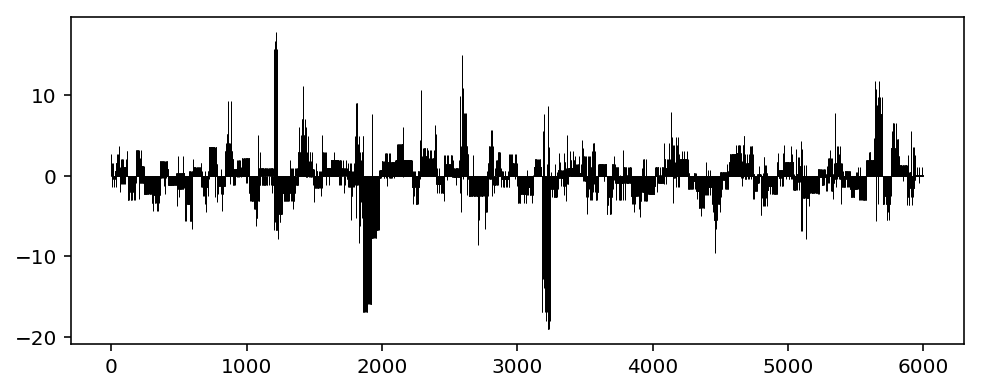

In [24]:
fig, ax = plt.subplots(figsize = (8,3), dpi = 144)
plt.vlines(range(len(pred_b)), 0, true_b- pred_b, lw = 0.5)


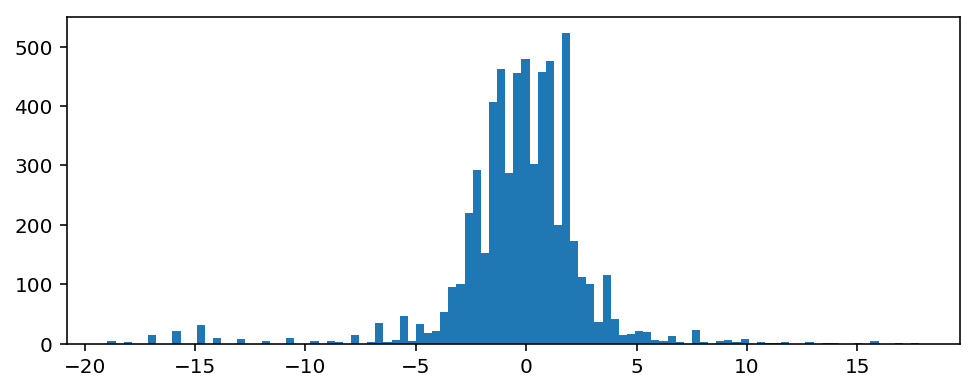

In [25]:
fig, ax = plt.subplots(figsize = (8,3), dpi = 144)
plt.hist(true_b- pred_b, bins = 100);

In [26]:
np.std(np.abs(true_b- pred_b))

2.3486669303428727

In [27]:
A = tester.A

In [28]:
x_prediction_eval = np.linalg.lstsq(A[:, tester.unique_ants], pred_b, rcond = None)

In [29]:
x_prediction = x_prediction_eval[0]

In [30]:
x_prediction

array([  80.53188813,   52.29513749,   51.67631295, -101.01743818,
         76.12112608,   35.98163194,   12.16703832,  -25.87346451,
        -88.45694588,   -2.20556915,  -21.22551713,   -2.32608944,
         42.48472666,  -88.50580419,  -54.87881443,   50.28615893,
         33.46720106,   21.70603134,   60.94127252,  -86.05451904,
         48.9631517 ,   -7.23343721,  -60.36664264,  -39.86371298,
         55.48851999,  -93.87860376,  -89.15737724,  -45.10674816,
        -71.95139141,   68.76424984,  -36.16968734,   76.04532271,
         -3.8535029 ,  -15.08290795,   95.73958541,   89.80550501,
         42.68478734,   61.25869578,  -51.07339956,   -6.75061158,
        -71.84768944,  -17.41048912,  -24.05469682,   80.31549467,
        -90.64978394,   58.27100613])

In [31]:
predicted_antenna_delays = {tester.unique_ants[i]: x_prediction[i] for i in range(len(x_prediction))}
predicted_antenna_delays

{1: 80.53188812935186,
 11: 52.29513749379282,
 12: 51.67631294930009,
 13: -101.01743817976009,
 14: 76.12112607501501,
 23: 35.98163193847883,
 24: 12.16703831505317,
 25: -25.873464507351052,
 26: -88.45694587873834,
 27: -2.2055691515551104,
 36: -21.225517130745036,
 37: -2.326089441595684,
 38: 42.48472666352656,
 39: -88.50580419474444,
 40: -54.87881442732121,
 41: 50.28615893123077,
 51: 33.467201056604296,
 52: 21.706031338626104,
 53: 60.94127251521858,
 54: -86.05451904258345,
 55: 48.963151702098855,
 65: -7.233437211479128,
 66: -60.36664264304467,
 67: -39.86371297653726,
 68: 55.48851998714331,
 69: -93.87860376065503,
 70: -89.15737723665347,
 71: -45.106748159482635,
 82: -71.95139140749792,
 83: 68.7642498443633,
 84: -36.169687335111576,
 86: 76.04532270515618,
 87: -3.8535028950408616,
 88: -15.082907947184871,
 120: 95.73958540888108,
 121: 89.80550500568918,
 122: 42.68478733732789,
 123: 61.25869578340064,
 124: -51.073399560609715,
 137: -6.750611582397134,
 13

In [32]:
error = {}
error_ls = []
for key in sorted(predicted_antenna_delays.keys()):
    print('{:3d}: {:6.2f}, {:6.2f}'.format(key,predicted_antenna_delays[key], scale_delays_to_ns(generated_ant_delays[key])))
    error[key] = scale_delays_to_ns(generated_ant_delays[key]) - predicted_antenna_delays[key]
    error_ls.append(error[key])

  1:  80.53,  95.32
 11:  52.30,  55.38
 12:  51.68,  60.00
 13: -101.02, -85.09
 14:  76.12, 100.50
 23:  35.98,  34.76
 24:  12.17,  10.32
 25: -25.87, -14.46
 26: -88.46, -68.99
 27:  -2.21,  21.33
 36: -21.23, -27.42
 37:  -2.33,   2.54
 38:  42.48,  48.11
 39: -88.51, -75.30
 40: -54.88, -33.75
 41:  50.29,  76.79
 51:  33.47,  28.08
 52:  21.71,  21.00
 53:  60.94,  67.38
 54: -86.05, -70.13
 55:  48.96,  72.10
 65:  -7.23, -23.61
 66: -60.37, -69.88
 67: -39.86, -43.10
 68:  55.49,  59.04
 69: -93.88, -82.02
 70: -89.16, -71.77
 71: -45.11, -19.33
 82: -71.95, -86.58
 83:  68.76,  61.46
 84: -36.17, -37.28
 86:  76.05,  88.08
 87:  -3.85,  15.15
 88: -15.08,  10.51
120:  95.74,  91.23
121:  89.81,  92.08
122:  42.68,  51.63
123:  61.26,  76.99
124: -51.07, -28.85
137:  -6.75, -28.82
138: -71.85, -86.39
139: -17.41, -27.71
140: -24.05, -26.13
141:  80.32,  84.92
142: -90.65, -81.27
143:  58.27,  76.50


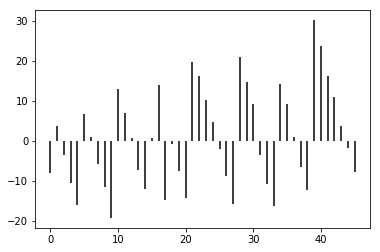

In [146]:
plt.vlines(range(len(error_ls)), 0, error_ls)